In [1]:
import stan as ps
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import xarray as xr
import arviz as az
az.style.use("arviz-darkgrid")
from patsy import dmatrix
import os
from scipy.stats import norm
# Importing nest_asyncio is only necessary to run pystan in Jupyter Notebooks.
import nest_asyncio
nest_asyncio.apply()


In [ ]:

# Specify the number of chains to the number of availible cpu's.
n_chains = os.cpu_count()
n_samples = 500
#Convert to int so Stan will not crash below.
n_warmup = int(n_samples/2)
#Specify step size.
stepS = .8

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

In [2]:
# Define plotting utility functions
def format_x_axis(ax, minor=False):
    # major ticks
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y %b"))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.grid(which="major", linestyle="-", axis="x")
    # minor ticks
    if minor:
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y %b"))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(which="minor", linestyle=":", axis="x")
    # rotate labels
    for label in ax.get_xticklabels(which="both"):
        label.set(rotation=70, horizontalalignment="right")
def plot_xY(x, Y, ax):
    quantiles = Y.quantile((0.025, 0.25, 0.5, 0.75, 0.975), dim=("chain", "draw")).transpose()

    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.025, 0.975]),
        fill_kwargs={"alpha": 0.25},
        smooth=False,
        ax=ax,
    )
    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.25, 0.75]),
        fill_kwargs={"alpha": 0.5},
        smooth=False,
        ax=ax,
    )
    ax.plot(x, quantiles.sel(quantile=0.5), color="C1", lw=3)


# default figure sizes
figsize = (10, 5)

In [36]:
treatment_time = "2017-01-01"
β0 = 0
β1 = 0.1
dates = pd.date_range(
    start=pd.to_datetime("2010-01-01"), end=pd.to_datetime("2020-01-01"), freq="M"
)
N = len(dates)


def causal_effect(df):
    return (df.index > treatment_time) * 2


df = (
    pd.DataFrame()
    .assign(time=np.arange(N), date=dates)
    .set_index("date", drop=True)
    .assign(y=lambda x: β0 + β1 * x.time + causal_effect(x) + norm(0, 0.5).rvs(N))
)


In [37]:
# Split into pre and post intervention dataframes
pre = df[df.index < treatment_time]
post = df[df.index >= treatment_time]

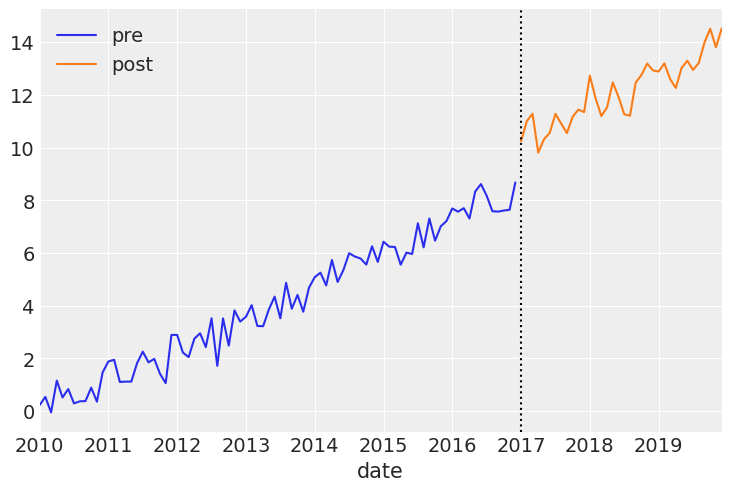

In [38]:
fig, ax = plt.subplots()
ax = pre["y"].plot(label="pre")
post["y"].plot(ax=ax, label="post")
ax.axvline(treatment_time, c="k", ls=":")
plt.legend();

In [6]:
interuptTS = ''' data {
int<lower=0> N_pre;   // number of data items pre intervention
int<lower =0> N_post;  // number of data items pre intervention 
int<lower=0> K;   // number of predictors
    
vector[N_pre]  y_pre;
matrix[N_pre, K] X_pre;

vector[N_post]  y_post;
matrix[N_post, K] X_post;

// Prior values
real sdS;
real sdB;

// Run likelihood for posterior predictive or not for prior predictive checks
  int<lower= 0, upper = 1> onlyprior;
}
parameters {

vector[K] beta;       // coefficients for predictors
real<lower=0> sigma;  // error scale
}
transformed parameters{
vector[N_pre] mu_pre;
mu_pre = X_pre * beta;
}
model {
// Priors 

beta ~ normal(0,sdB);
sigma ~ normal(0,sdS);
    
// likelihood    
if (!onlyprior){
y_pre ~ normal(mu_pre , sigma);  
    }
}
generated quantities{
// Priro/Posterior predicitive checks
// Model fit assessment
array[N_pre] real yrep;
yrep = multi_normal_rng(mu_pre, sigma);

// Post intervention prediction
vector[N_post] mu_post;
mu_post = X_post * beta;
array[N_post] real yPostPred;
yPostPred = normal_rng(mu_post, sigma);

//Calculate residuals
vector[N_pre] resids = y_pre - to_vector(yrep);
// Calculate causal impact 
vector[N_pre] pre_impact = y_pre - mu_pre;
vector[N_post] post_impact = y_post - mu_post;
vector[N_post] post_impact_cumulative = cumulative_sum(post_impact);

}
'''

In [7]:
X_pre = np.asarray(dmatrix("~ + time", data = pre ))
X_post = np.asarray(dmatrix("~ + time", data = post ))
y_pre = pre['y'].values
y_post = post['y'].values

In [8]:
d_prior = {
        ## Set to one for prior predictive checks
        'onlyprior': 1,
         'N_pre': len(y_pre),
        'N_post': len(y_post),
        'K': X_pre.shape[1],
        'y_pre': y_pre,
        'X_pre': X_pre,
        'y_post': y_post,
        'X_post': X_post,        
        'sdS': 2,
        'sdB': .2
        }

d_posterior = {
        ## Set to zero for prior predictive checks
        'onlyprior': 0,
         'N_pre': len(y_pre),
        'N_post': len(y_post),
        'K': X_pre.shape[1],
        'y_pre': y_pre,
        'X_pre': X_pre,
        'y_post': y_post,
        'X_post': X_post,        
        'sdS': 2,
        'sdB': .2
        }
        
# Build stan model for prior and posterior checks/estimation data
sm_prior = ps.build(interuptTS, data=d_prior) 
sm_posterior = ps.build(interuptTS, data=d_posterior) 

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [9]:
# Fit stan model to data.
fitITPrior = sm_prior.sample(num_chains = n_chains , num_samples = n_samples, num_warmup = n_warmup, stepsize = stepS);
fitITPost = sm_posterior.sample(num_chains = n_chains , num_samples = n_samples, num_warmup = n_warmup, stepsize = stepS);

Sampling:   0%
Sampling:  12% (750/6000)
Sampling:  25% (1500/6000)
Sampling:  38% (2250/6000)
Sampling:  50% (3000/6000)
Sampling:  62% (3750/6000)
Sampling:  75% (4500/6000)
Sampling:  88% (5250/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 5.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.59 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.5e-05 se

In [10]:
# COnvert to infernece object.
idata_prior = az.from_pystan(posterior=fitITPrior, posterior_model=sm_prior, 
                       posterior_predictive=['yrep'], observed_data=  ['y_pre']) 
idata_post =  az.from_pystan(posterior=fitITPost, posterior_model=sm_posterior, 
                       posterior_predictive=['yrep'], observed_data=  ['y_pre']) 

In [17]:
# Output results of the model fit.
az.summary(idata_post, var_names=["beta", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.015,0.084,-0.140,0.178,0.002,0.002,1667.0,1286.0,1.01
beta[1],0.100,0.002,0.096,0.103,0.000,0.000,1997.0,1798.0,1.00
sigma,0.426,0.034,0.360,0.485,0.001,0.001,1693.0,1537.0,1.00


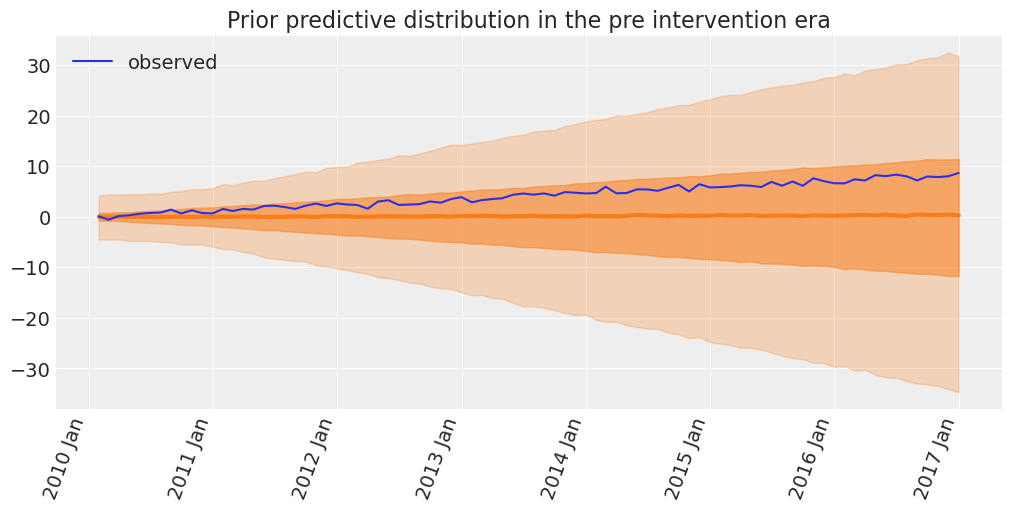

In [18]:
fig, ax = plt.subplots(figsize=figsize)

plot_xY(pre.index, idata_prior.posterior_predictive["yrep"], ax)
format_x_axis(ax)
ax.plot(pre.index, pre["y"], label="observed")
ax.set(title="Prior predictive distribution in the pre intervention era")
plt.legend();

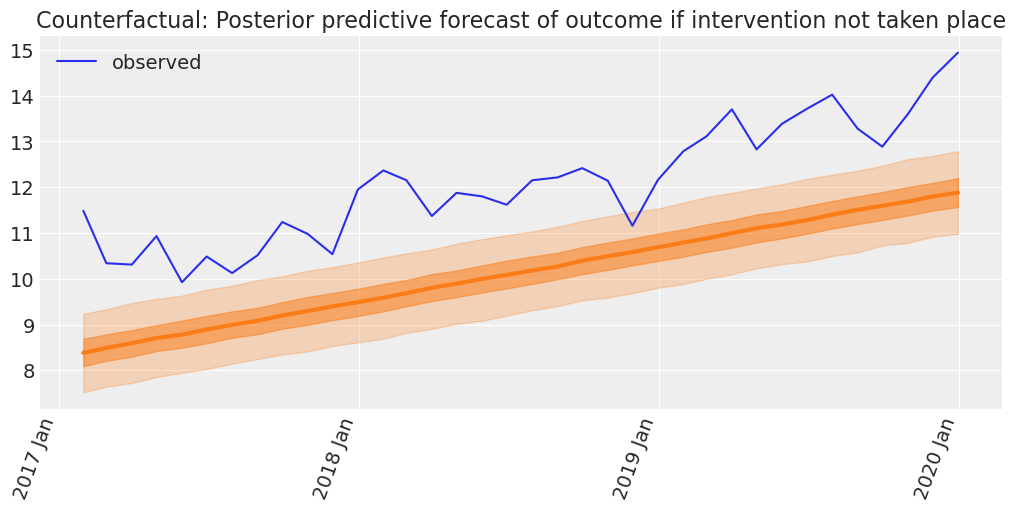

In [13]:
fig, ax = plt.subplots(figsize=figsize)

plot_xY(post.index, idata_post.posterior["yPostPred"], ax)
format_x_axis(ax, minor=False)
ax.plot(post.index, post["y"], label="observed")
ax.set(
    title="Counterfactual: Posterior predictive forecast of outcome if intervention not taken place"
)
plt.legend();

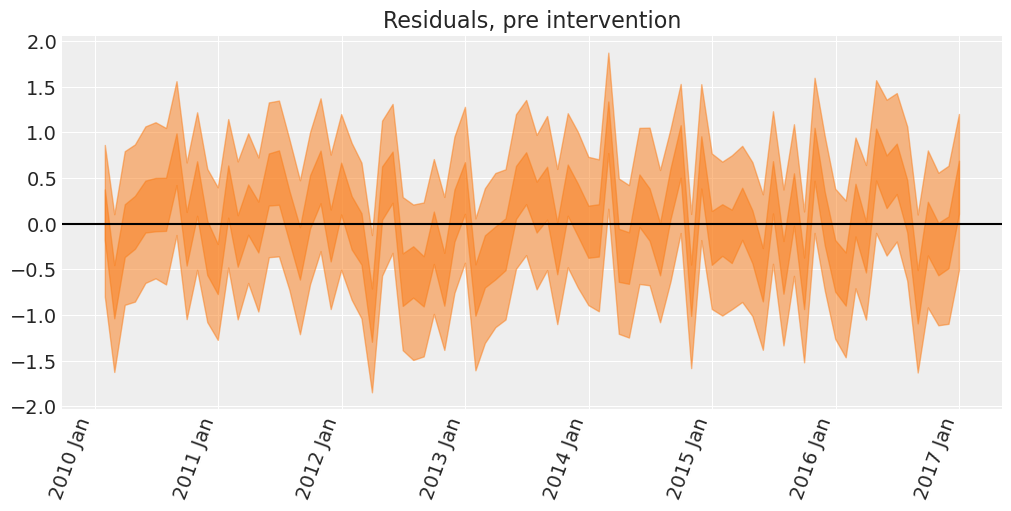

In [14]:
fig, ax = plt.subplots(figsize=figsize)
# the transpose is to keep arviz happy, ordering the dimensions as (chain, draw, time)
az.plot_hdi(pre.index, idata_post.posterior["resids"], hdi_prob=0.5, smooth=False)
az.plot_hdi(pre.index, idata_post.posterior["resids"], hdi_prob=0.95, smooth=False)
format_x_axis(ax)
ax.axhline(y=0, color="k")
ax.set(title="Residuals, pre intervention");

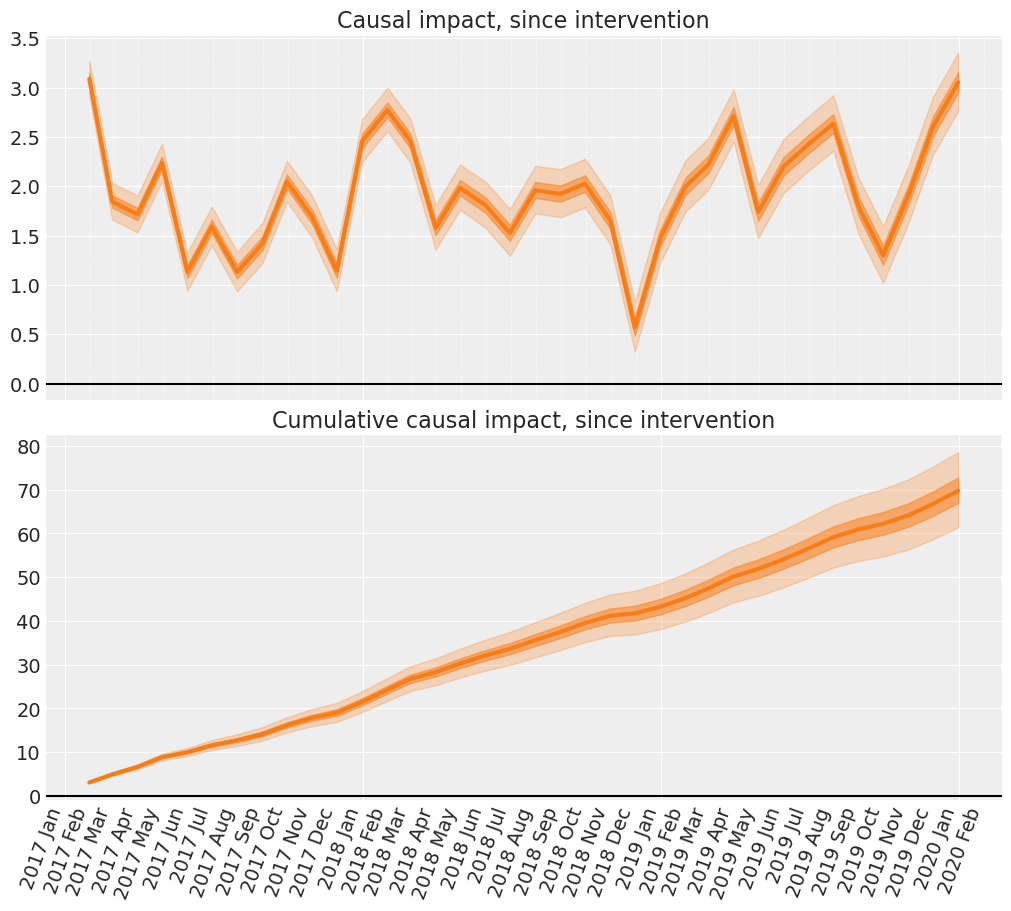

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(figsize[0], 9), sharex=True)

# Plot the excess
# The transpose is to keep arviz happy, ordering the dimensions as (chain, draw, t)
plot_xY(post.index, idata_post.posterior['post_impact'], ax[0])
format_x_axis(ax[0], minor=True)
ax[0].axhline(y=0, color="k")
ax[0].set(title="Causal impact, since intervention")

# Plot the cumulative excess
plot_xY(post.index, idata_post.posterior['post_impact_cumulative'], ax[1])
format_x_axis(ax[1], minor=False)
ax[1].axhline(y=0, color="k")
ax[1].set(title="Cumulative causal impact, since intervention");